In [55]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap

In [58]:
# load in occurrence data produced during the geo_alignment process
occ = pd.read_csv("peromyscus_concepts.csv", low_memory=False)
occ = geopandas.GeoDataFrame(occ, geometry=geopandas.points_from_xy(occ['decimalLongitude'], occ['decimalLatitude']))
#occ = occ.sample(5000) #useful for development

# set an appropriate projection for the figure
project = "EPSG:2163"

# load geopandas' background for North America as a base map
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.continent == 'North America'] # restrict to North America
world = world.to_crs(project)

# convert a subset of columns from occurrences into a geodataframe
gdb_occ = geopandas.GeoDataFrame(occ[['geometry', 'suggested_names', 'acceptedScientificName']], geometry='geometry')

# organize and align terms
gdb_occ.rename(columns={"acceptedScientificName":"GBIF_names"}, inplace=True)
gdb_occ.loc[gdb_occ['GBIF_names']=='Peromyscus maniculatus (Wagner, 1845)', 'GBIF_names'] = "P. maniculatus (Wagner 1845)"

# set current projection then reproject for figure production
gdb_occ = gdb_occ.set_crs("EPSG:4326") # default from gbif
gdb_occ = gdb_occ.to_crs(project)

In [74]:
# colorblind friendly map adapted from: https://gist.github.com/thriveth/8560036
color_map = {'P. arcticus (Wagner 1845)':'#a65628',
             'P. gambelii (Baird 1857)':'#4daf4a',
             'P. labecula (Elliot 1903)':'#f781bf',
             'P. maniculatus (Wagner 1845)':'#377eb8',
             'P. sonoriensis (LeConte 1853)':'#ff7f00',
             #'two suggested names': '#e41a1c',
             'two suggested names': 'tab:gray',
             'out of range':'#dede00',
            }


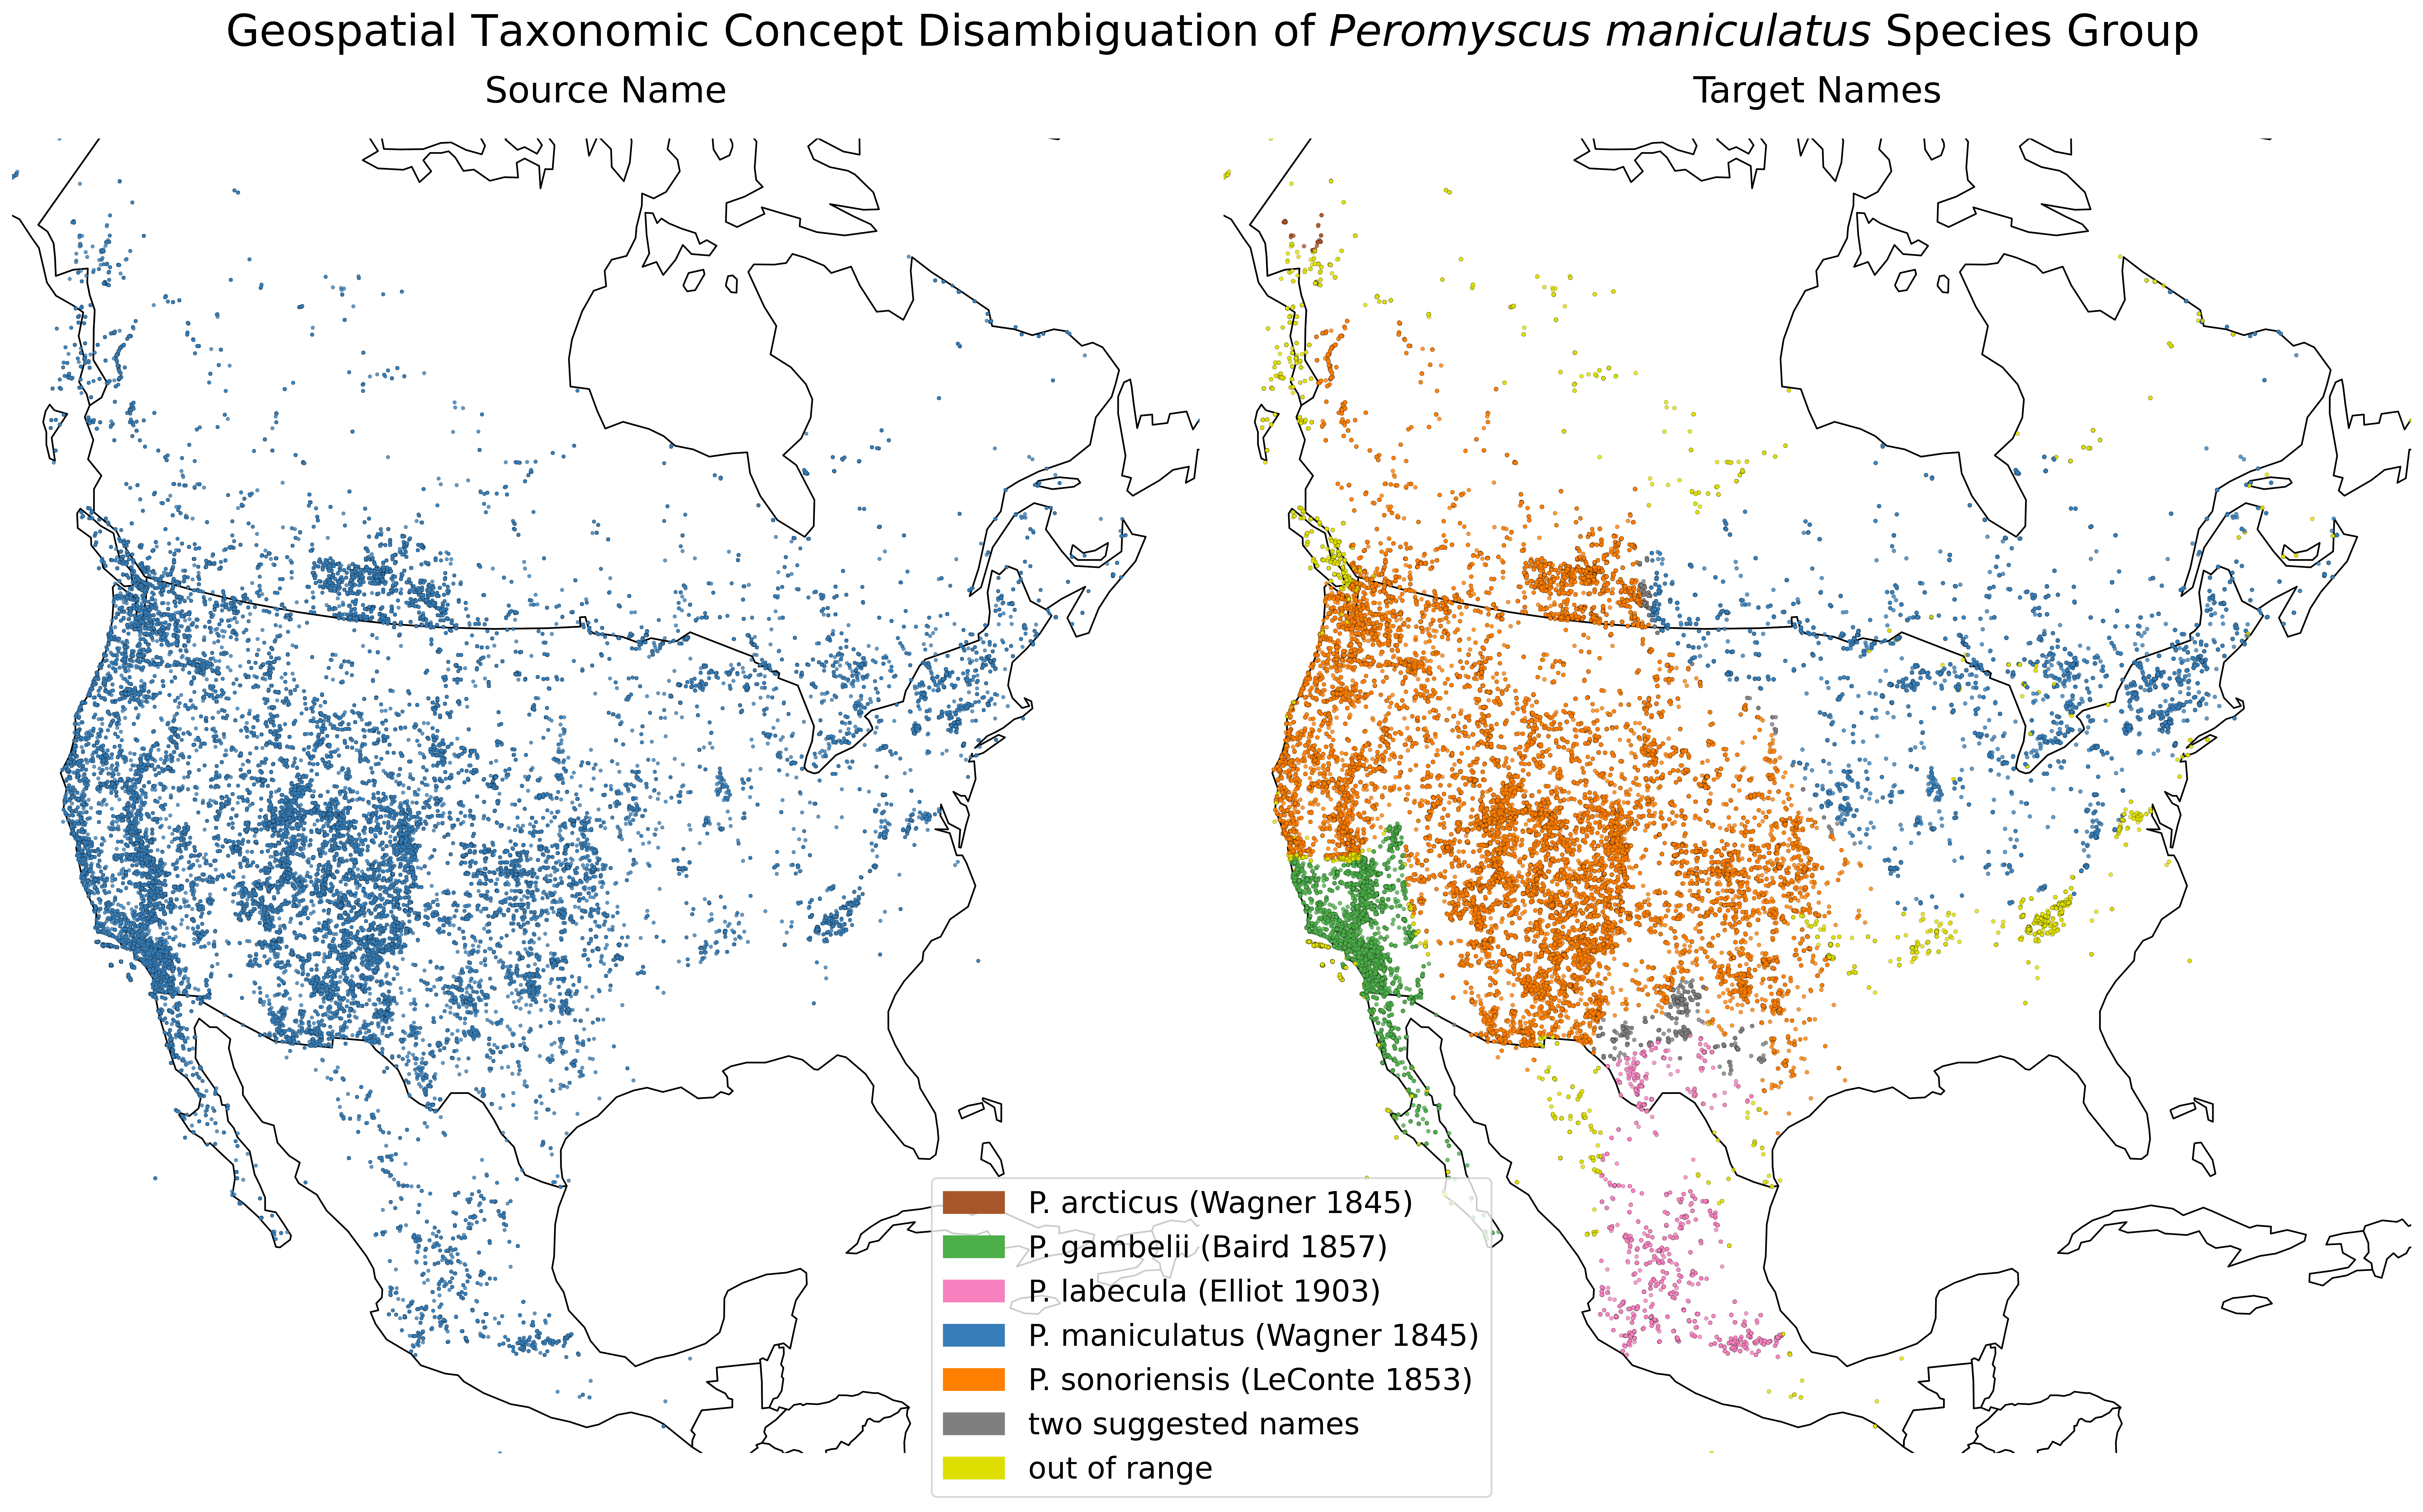

In [75]:
try: # try except block clears previous plotting attempts which may be in ram during development
    plt.clear() 
except:
    pass

plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 18
# establish a multi-plot fig.
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20,12))
suptitle = plt.suptitle("Geospatial Taxonomic Concept Disambiguation of $\it{Peromyscus}$ $\it{maniculatus}$ Species Group",
                        y=1.04, #y param shifts the title slightly up and away from subplot labels
                        fontsize=26)


# enumerate over each subplot and establish bounds.
for idx, target_feature in enumerate(['GBIF_names', 'suggested_names']):
    padding = 30
    minx, miny, maxx, maxy = gdb_occ.total_bounds
    axs[idx].set_xlim(minx-padding, maxx+padding)
    axs[idx].set_ylim(miny-padding, maxy+padding)
    axs[idx].axis("off")


plt.subplot(1,2,1) # start with "GBIF_names" subplot
base = world.plot(ax= axs[0], color='white', edgecolor='black') # setup the subplot's base map
plt.title("Source Name",
          y=1.02) #y param shifts the subplot title slightly up and away from Canada
gdb_occ.plot(ax=base,
            #column='GBIF_names',
            categorical=True,
            #cmap='tab10',
            color=color_map.get('P. maniculatus (Wagner 1845)'),
            label=gdb_occ["GBIF_names"],
            marker="o",
            markersize=5,
            alpha=.8,
            edgecolors='k',
            linewidth=0.08,
            legend=False)

plt.subplot(1,2,2) # plot suggested_names subplot
base = world.plot(ax= axs[1], color='white', edgecolor='black')
plt.title("Target Names",
          y=1.02) #y param shifts the subplot title slightly up and away from Canada
gdb_occ.plot(ax=base,
            #column='suggested_names',
            categorical=True,
            color=gdb_occ['suggested_names'].map(color_map),
            label=gdb_occ['suggested_names'],
            marker="o",
            markersize=6,
            alpha=.8,
            edgecolors='k',
            linewidth=0.08)

# generate a shared legend

handles= [mpatches.Patch(color=v, label=k) for k, v in color_map.items()]
fig.legend(handles=handles,
           loc='lower center')

plt.savefig("Peromyscus_fig.jpg", pad_inches=0, bbox_inches='tight', bbox_extra_artists=[suptitle])
plt.show()